In [1]:
import seaborn as sns
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA, NMF
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, mean_squared_error


In [2]:
with open('preprocessed_data/original_data.pkl', 'rb') as f:
    data = pickle.load(f)
    print(data)
    print(len(data))
    


      has_null  wave  gender   age  age_o  d_age  d_d_age  race  race_o  \
0          0.0   1.0     0.0  21.0   27.0    6.0      2.0   0.0     3.0   
1          0.0   1.0     0.0  21.0   22.0    1.0      0.0   0.0     3.0   
2          1.0   1.0     0.0  21.0   22.0    1.0      0.0   0.0     0.0   
3          0.0   1.0     0.0  21.0   23.0    2.0      1.0   0.0     3.0   
4          0.0   1.0     0.0  21.0   24.0    3.0      1.0   0.0     2.0   
...        ...   ...     ...   ...    ...    ...      ...   ...     ...   
8373       1.0  21.0     1.0  25.0   26.0    1.0      0.0   3.0     2.0   
8374       1.0  21.0     1.0  25.0   24.0    1.0      0.0   3.0     4.0   
8375       1.0  21.0     1.0  25.0   29.0    4.0      2.0   3.0     2.0   
8376       1.0  21.0     1.0  25.0   22.0    3.0      1.0   3.0     0.0   
8377       1.0  21.0     1.0  25.0   22.0    3.0      1.0   3.0     0.0   

      samerace  ...  field_14  field_15  field_16  field_17  race_0.0  \
0          0.0  ...       

#### Show correlation between self-reported scores and scores given by the opponent 

              attractive  attractive_o
attractive      1.000000      0.351675
attractive_o    0.351675      1.000000
            sincere  sinsere_o
sincere    1.000000  -0.060649
sinsere_o -0.060649   1.000000
            funny   funny_o
funny    1.000000  0.022237
funny_o  0.022237  1.000000
            ambition  ambitous_o
ambition    1.000000    0.272526
ambitous_o  0.272526    1.000000
                intelligence  intelligence_o
intelligence        1.000000        0.014691
intelligence_o      0.014691        1.000000


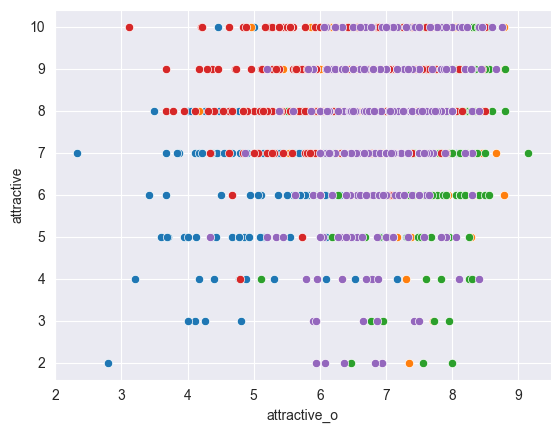

In [3]:
self_rated_features = ['attractive', 'sincere', 'intelligence', 'funny', 'ambition']
average_columns = [ 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o']
group_by_columns = ['gender', 'age', 'race', 'field', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga']

def compare_ratings(data):
    combined_df = (
    data.groupby(group_by_columns, as_index=False)
    [average_columns].mean()
    )
    reduced_df = combined_df[self_rated_features + average_columns]
    
    corr_attractive = reduced_df[['attractive', 'attractive_o']].corr()
    corr_sincere = reduced_df[['sincere', 'sinsere_o']].corr()
    corr_intelligence = reduced_df[['intelligence', 'intelligence_o']].corr()
    corr_funny = reduced_df[['funny', 'funny_o']].corr()
    corr_ambition = reduced_df[['ambition', 'ambitous_o']].corr()
    
    print(corr_attractive)
    print(corr_sincere)
    print(corr_funny)
    print(corr_ambition)
    print(corr_intelligence)
    
    sns.scatterplot(reduced_df, x="attractive_o", y="attractive")
    sns.scatterplot(reduced_df, x="sinsere_o", y="sincere")
    sns.scatterplot(reduced_df, x="intelligence_o", y="intelligence")
    sns.scatterplot(reduced_df, x="funny_o", y="funny")
    sns.scatterplot(reduced_df, x="ambitous_o", y="ambition")  
   
    

women = data.loc[data['gender'] == 0]
men = data.loc[data['gender'] == 1]

compare_ratings(men)  


    

In [4]:
def remove_relational_data(data):
    data = data[['gender', 'age', 'race', 'field', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'shared_interests_o']]
    return data

data = remove_relational_data(data)    

In [5]:
combined_df = (
    data.groupby(group_by_columns, as_index=False)
    [average_columns].mean()
)

In [6]:
# Select women
combined_df = combined_df.loc[combined_df['gender'] == 0]

# Select men
#combined_df = combined_df.loc[combined_df['gender'] == 1]

##### Normalize features

In [7]:
std_scaler = StandardScaler()
normalized_features = std_scaler.fit_transform(combined_df)
min_max_scaler = MinMaxScaler()
normalized_features = min_max_scaler.fit_transform(normalized_features)
print(normalized_features.shape)

(271, 37)


##### Apply PCA

(271, 37)
Cumulative variance explained by 2 principal components: 22.21%
Cumulative variance explained by 3 principal components: 31.23%
Cumulative variance explained by 4 principal components: 38.65%
Cumulative variance explained by 5 principal components: 44.67%
Cumulative variance explained by 6 principal components: 49.47%
Cumulative variance explained by 7 principal components: 54.12%
Cumulative variance explained by 8 principal components: 58.11%
Cumulative variance explained by 9 principal components: 61.99%
Cumulative variance explained by 10 principal components: 65.49%
Cumulative variance explained by 11 principal components: 68.69%
Cumulative variance explained by 12 principal components: 71.67%
Cumulative variance explained by 13 principal components: 74.38%
Cumulative variance explained by 14 principal components: 76.81%


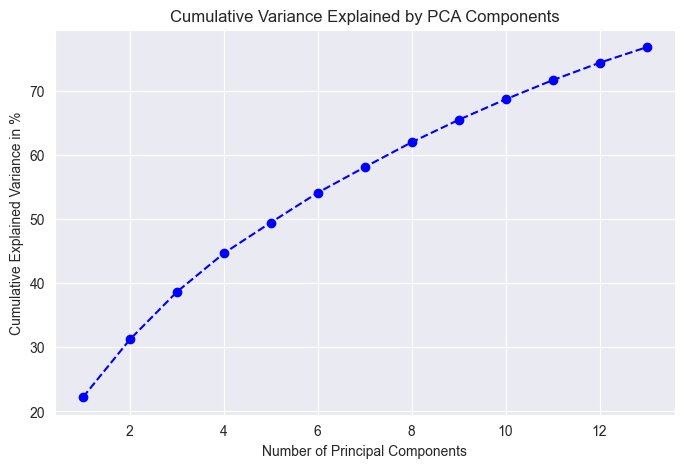

In [8]:
print(normalized_features.shape)
pca_reduced_features = []
cumul_variance = []
pca_reconstruction_errors = []

for n in range(2,15):
    pca = PCA(n_components=n)
    reduced_features = pca.fit_transform(normalized_features)
    pca_reduced_features.append(reduced_features)
    cumul_variance.append(np.sum(pca.explained_variance_ratio_) *100)
    
    X_pca_reconstructed = pca.inverse_transform(reduced_features)
    pca_error = mean_squared_error(normalized_features, X_pca_reconstructed)
    pca_reconstruction_errors.append(pca_error)
    
    print('Cumulative variance explained by {} principal components: {:.2%}'.format(n, np.sum(pca.explained_variance_ratio_)))
    
# Plot cumulative variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumul_variance) + 1), cumul_variance, marker='o', linestyle='--', color='b')
plt.title('Cumulative Variance Explained by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance in %')
plt.grid(True)
plt.show()



##### Apply NMF

Reconstruction error by 2 components: 1905.11%
Reconstruction error by 3 components: 1798.11%
Reconstruction error by 4 components: 1692.35%
Reconstruction error by 5 components: 1614.51%
Reconstruction error by 6 components: 1538.55%
Reconstruction error by 7 components: 1473.44%
Reconstruction error by 8 components: 1408.52%
Reconstruction error by 9 components: 1346.85%
Reconstruction error by 10 components: 1286.84%
Reconstruction error by 11 components: 1221.62%
Reconstruction error by 12 components: 1163.49%
Reconstruction error by 13 components: 1102.74%
Reconstruction error by 14 components: 1051.16%


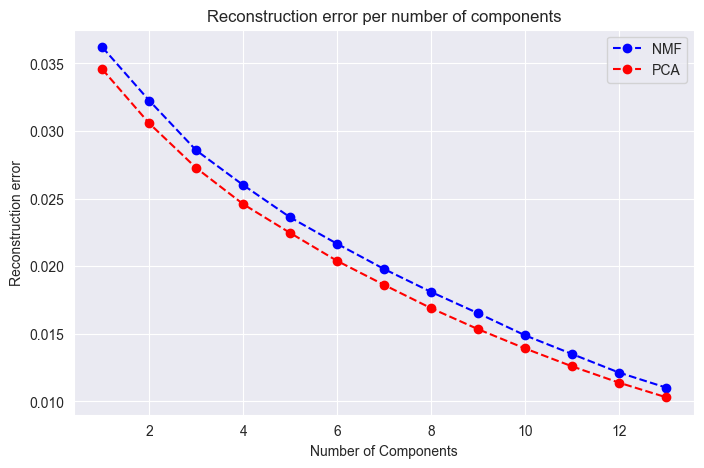

In [9]:
nmf_reduced_features = []
nmf_errors = []

for n in range(2,15):
    nmf_model = NMF(n_components=n, init='random', random_state=0, max_iter=5000)  # 3
    nmf_features = nmf_model.fit_transform(normalized_features)
    nmf_reduced_features.append(nmf_features)
    
    H = nmf_model.components_   
    X_nmf_reconstructed = np.dot(nmf_features, H)
    nmf_error = mean_squared_error(normalized_features, X_nmf_reconstructed)
    nmf_errors.append(nmf_error)
    
    print('Reconstruction error by {} components: {:.2%}'.format(n, nmf_model.reconstruction_err_))    
    
# Plot Reconstruction error
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(nmf_errors) + 1), nmf_errors, marker='o', linestyle='--', color='b', label='NMF')
plt.plot(range(1, len(pca_reconstruction_errors) + 1), pca_reconstruction_errors, marker='o', linestyle='--', color='r', label='PCA')
plt.legend()
plt.title('Reconstruction error per number of components')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction error')
plt.grid(True)
plt.show()
    


### K-means - Partitional Clustering Techniques

#### Generalized fitting and tuning function

In [10]:
def tune_model(parameter_grid, model, data, show_silhouette, isKmeans):
    inertias = []
    if isKmeans:
        distortions = []
        inertias = []
        
        mapping1=  {}  
        mapping2=  {}    

    best_score = -1        
    silhouette_scores = []
    
    # evaluation based on silhouette_score
    for p in parameter_grid:
        model.set_params(**p)    # Set current hyperparameters
        model.fit(data) 
        
        if len(set(model.labels_)) > 2:
            ss = silhouette_score(data, model.labels_)   
            silhouette_scores += [ss]     
            if show_silhouette:
                print('Parameter:', p, 'Score', ss)
            
            if isKmeans:
                distortions.append(sum(np.min(cdist(data, model.cluster_centers_, 'euclidean'), axis=1)**2) / data.shape[0])      
                inertias.append(model.inertia_)
            
                k = p['n_clusters']
                # Store the mappings for easy access
                mapping1[k] = distortions[-1]
                mapping2[k] = inertias[-1]
                # check p which has the best score
            
            if ss > best_score:
                best_score = ss
                best_grid = p
        
    if show_silhouette:      
        # plotting silhouette score
        plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
        plt.xticks(range(len(silhouette_scores)), range(len(list(silhouette_scores))))
        plt.title('Silhouette Score', fontweight='bold')
        plt.xlabel('Number of Clusters')
        plt.show()
    
    return inertias, silhouette_scores

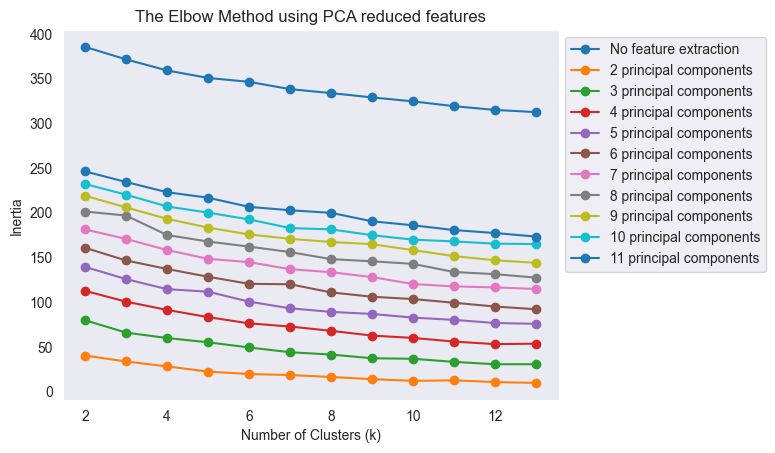

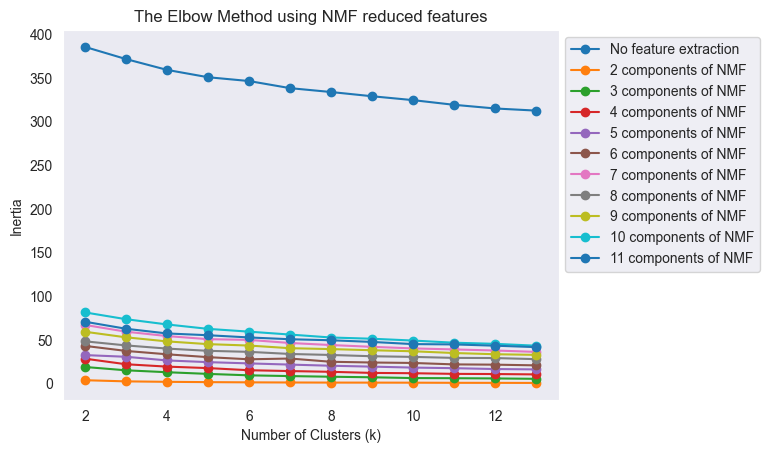

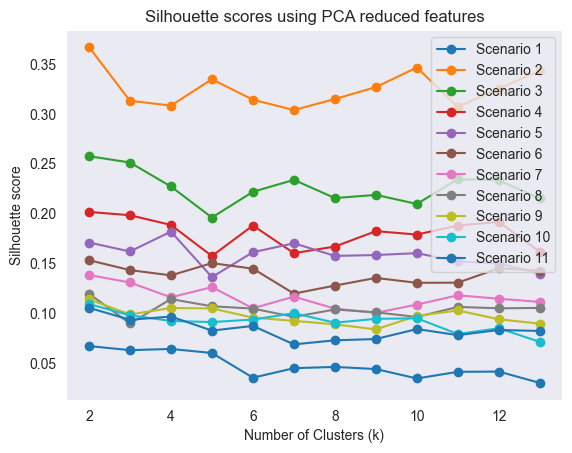

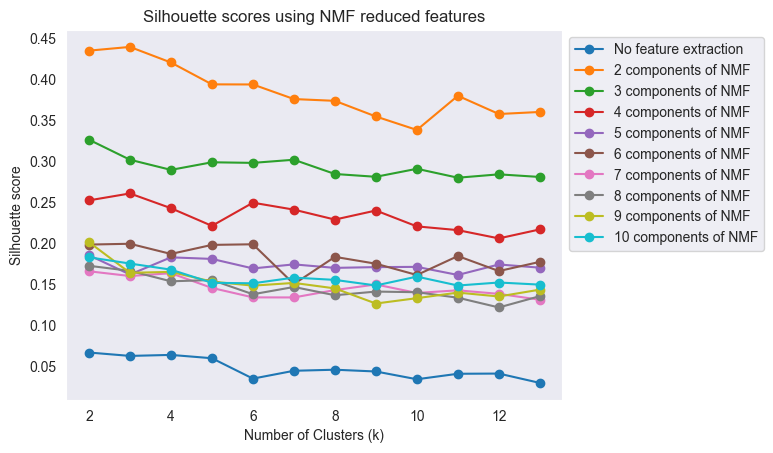

In [11]:
### Only the KMeans model can set the last parameter (isKmeans) of tune_model to True, as only the Kmeans model has an inertia and distortion attribute
    
model = KMeans()
parameters = range(2,15)
parameter_grid = ParameterGrid({'n_clusters': parameters, 'n_init': ['auto']})

inertia_nmf = []
inertia_pca = []
silhouette_scores_nmf = []
silhouette_scores_pca = []

#distortions.append(tune_model(parameter_grid, model, combined_df, False, True))
result = tune_model(parameter_grid, model, normalized_features, False, True)
inertia_nmf.append(result[0])
inertia_pca.append(result[0])
silhouette_scores_nmf.append(result[1])
silhouette_scores_pca.append(result[1])


for rf in pca_reduced_features:
    result = tune_model(parameter_grid, model, rf, False, True)
    inertia_pca.append(result[0])
    silhouette_scores_pca.append(result[1])
for nmf in nmf_reduced_features:
    result = tune_model(parameter_grid, model, nmf, False, True)
    inertia_nmf.append(result[0])
    silhouette_scores_nmf.append(result[1])

    
# Plotting the graph of k versus Inertia
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using PCA reduced features')
plt.grid()
clusters = range(2,14)
plt.plot(clusters, inertia_pca[0], marker='o', linestyle='-', label='No feature extraction')
for i, distortion_list in enumerate(inertia_pca[1:11]):
    plt.plot(clusters, distortion_list, marker='o', linestyle='-', label=f'{i+2} principal components')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
    
    

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('The Elbow Method using NMF reduced features')
plt.grid()
clusters = range(2,14)
plt.plot(clusters, inertia_nmf[0], marker='o', linestyle='-', label='No feature extraction')
for i, distortion_list in enumerate(inertia_nmf[1:11]):
    plt.plot(clusters, distortion_list, marker='o', linestyle='-', label=f'{i+2} components of NMF')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores using PCA reduced features')
plt.grid()
clusters = range(2,14)
for i, distortion_list in enumerate(silhouette_scores_pca[0:11]):
    plt.plot(clusters, distortion_list, marker='o', linestyle='-', label=f'Scenario {i+1}')
plt.legend()
plt.show()


plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores using NMF reduced features')
plt.grid()
clusters = range(2,14)
plt.plot(clusters, silhouette_scores_nmf[0], marker='o', linestyle='-', label='No feature extraction')

for i, distortion_list in enumerate(silhouette_scores_nmf[1:10]):
    plt.plot(clusters, distortion_list, marker='o', linestyle='-', label=f'{i+2} components of NMF')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()



    
    




### Hierarchical Clustering

{'linkage': 'ward', 'n_clusters': 2}
0.502595876072491
{'linkage': 'ward', 'n_clusters': 3}
0.42472472673155287
{'linkage': 'ward', 'n_clusters': 4}
0.40265213875127065
{'linkage': 'ward', 'n_clusters': 5}
0.3962095084533084
{'linkage': 'ward', 'n_clusters': 6}
0.38721433426684765
{'linkage': 'ward', 'n_clusters': 7}
0.38699643378650805
{'linkage': 'ward', 'n_clusters': 8}
0.3510509457657004
{'linkage': 'ward', 'n_clusters': 9}
0.3410468337901666
{'linkage': 'ward', 'n_clusters': 10}
0.3470969341626917
{'linkage': 'complete', 'n_clusters': 2}
0.497844954512161
{'linkage': 'complete', 'n_clusters': 3}
0.41389116585321817
{'linkage': 'complete', 'n_clusters': 4}
0.40611348684435294
{'linkage': 'complete', 'n_clusters': 5}
0.3407530597154278
{'linkage': 'complete', 'n_clusters': 6}
0.3218762727446501
{'linkage': 'complete', 'n_clusters': 7}
0.30522836827775107
{'linkage': 'complete', 'n_clusters': 8}
0.3040081530896021
{'linkage': 'complete', 'n_clusters': 9}
0.27688485685846415
{'linkage

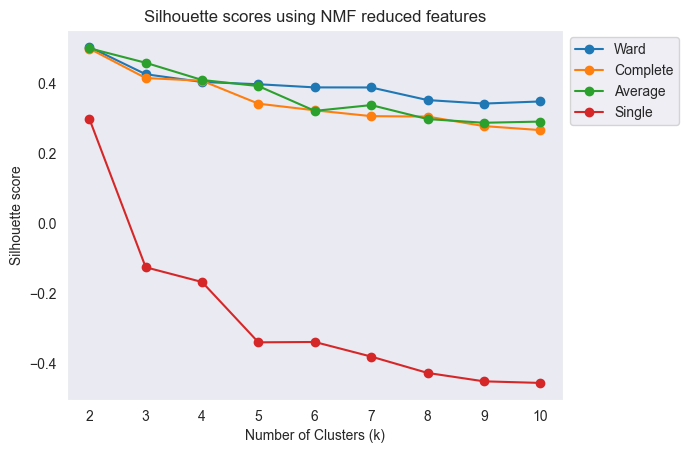

In [12]:
parameters = range(2,11)
parameter_grid = ParameterGrid({'n_clusters': parameters , 'linkage':['ward', 'complete', 'average', 'single']})
agglom = AgglomerativeClustering()

best_score = 0
silhouette_scores = []

for p in parameter_grid:
        agglom.set_params(**p)    # Set current hyperparameters
        agglom.fit(nmf_reduced_features[0]) 
        
        #if len(set(agglom.labels_)) > 2:
        ss = silhouette_score(nmf_reduced_features[0], agglom.labels_)   
        silhouette_scores += [ss]     
        
        if ss > best_score:
            best_score = ss
            best_grid = p
        print(p)
        print(ss)


plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores using NMF reduced features')
plt.grid()


plt.plot(range(2,11), silhouette_scores[0:9], marker='o', linestyle='-', label='Ward')
plt.plot(range(2,11), silhouette_scores[9:18], marker='o', linestyle='-', label='Complete')
plt.plot(range(2,11), silhouette_scores[18:27], marker='o', linestyle='-', label='Average')
plt.plot(range(2,11), silhouette_scores[27:36], marker='o', linestyle='-', label='Single')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

# tune_model(parameter_grid, agglom, combined_df, True, False)
# tune_model(parameter_grid, agglom, normalized_features, True, False)



[0.4344074536057436, 0.4389358133219901, 0.4199756497251066, 0.39335440249305725, 0.3932308407773615, 0.3754652110358302, 0.37329674158805476, 0.35424314780299165, 0.3378565345904813]
[0.502595876072491, 0.42472472673155287, 0.40265213875127065, 0.3962095084533084, 0.38721433426684765, 0.38699643378650805, 0.3510509457657004, 0.3410468337901666, 0.3470969341626917]


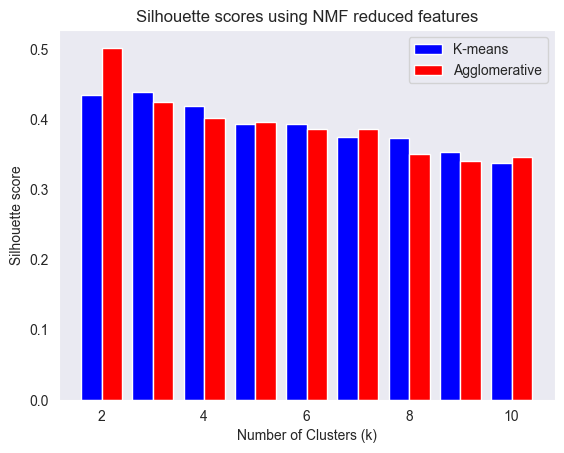

In [13]:
kmeans_best_ss = silhouette_scores_nmf[1][0:9]
hierarch_best_ss = silhouette_scores[0:9]
print(kmeans_best_ss)
print(hierarch_best_ss)
clusters = np.arange(2,11)

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores using NMF reduced features')
plt.bar(clusters-0.2, kmeans_best_ss, width=0.4, color='b', align='center', label='K-means')
plt.bar(clusters+0.2, hierarch_best_ss, width=0.4, color='r', align='center', label='Agglomerative')
plt.grid()
plt.legend()
plt.show()

### DBSCAN

In [14]:
dbscan = DBSCAN()
eps = [0.01, 0.02, 0.5]
min_samples = range(1,10)

parameter_grid = ParameterGrid({'eps':eps, 'min_samples':min_samples})

silhouette_scores = []

for p in parameter_grid:
        dbscan.set_params(**p)    # Set current hyperparameters
        dbscan.fit(nmf_reduced_features[0]) 
        
        if len(set(dbscan.labels_)) > 2:
            ss = silhouette_score(nmf_reduced_features[0], dbscan.labels_)   
            silhouette_scores += [ss]     
            
            if ss > best_score:
                best_score = ss
                best_grid = p
            
            print(p)
            print(ss)
        
        



{'eps': 0.01, 'min_samples': 1}
0.23084282966288616
{'eps': 0.01, 'min_samples': 2}
-0.24874833249741515
{'eps': 0.01, 'min_samples': 3}
-0.46529843836538554
{'eps': 0.01, 'min_samples': 4}
-0.5264674369631419
{'eps': 0.02, 'min_samples': 1}
0.21991846591182318
{'eps': 0.02, 'min_samples': 2}
0.1287204552364323
{'eps': 0.02, 'min_samples': 3}
-0.05061147558957996
{'eps': 0.02, 'min_samples': 4}
-0.1700154610156377
{'eps': 0.02, 'min_samples': 5}
-0.24469684071017944
{'eps': 0.02, 'min_samples': 6}
-0.3590743790490862
{'eps': 0.02, 'min_samples': 7}
-0.46987247808403804
{'eps': 0.02, 'min_samples': 8}
-0.40002350818670973
